In [47]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl
from scipy import stats, optimize
import matplotlib.pyplot as pl
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.anova as anova
from statsmodels.formula.api import ols
import seaborn as sns
import os
import fnmatch

In [48]:
def SumofSquares(x):
    x = np.array(x)
    return ((x - x.mean())**2).sum()
def SSW(db,groupBy='choice',value='rate'):
    ssw = 0
    for item in set(db[groupBy]):
        subset = db[db[groupBy] == item][value]
        groupMean =  subset.mean()
        
        #ssw += ((db[value] - groupMean)**2).sum()
        ssw += SumofSquares(subset)
    return ssw
def SSB(db,groupBy = 'choice',value='rate'):
    groupMean = []
    numberofGroups = len(set(db[groupBy]))
    for item in set(db[groupBy]):
        numberofObservationsWithin = db[db[groupBy] == item][value].size
        groupMean.append(db[db[groupBy] == item][value].mean())
        #print item,numberofObservationsWithin
    return SumofSquares(groupMean) * numberofObservationsWithin
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]

In [70]:
sns.set(style="whitegrid")
path = './dataFiles/'
sessionDbPaths = []
numberofPlaceCells = 0
numberofTimeInputs = 0
numberofDecisionInputs = 0
decisionCells = []
timeCells = []
placeCells = []
for item in locate('*.db',path):
    sessionDbPaths.append(os.path.join(item[0],item[1]))
for path in sessionDbPaths:
    cellDB = pkl.load(open(path,'rb'))
    place_cell_ids = []
    time_cell_ids = []
    decision_cell_ids = []
    for ii,item in enumerate(cellDB):
        result = ols("rate ~ choice + delay + C(position)",data=item).fit()
        anovaResult = anova_lm(result)
        p_values = anovaResult["PR(>F)"]
        significant_p =  np.where(p_values <= 0.05)[0]
        if significant_p.size:
            if np.where(significant_p==0)[0].size and item.rate.max()>5and item.rate.mean()>0.5:
                decision_cell_ids.append(ii)
                decisionCells.append(item)
            if np.where(significant_p==1)[0].size and item.rate.max()>5and item.rate.mean()>0.5:
                time_cell_ids.append(ii)
                timeCells.append(item)
            if np.where(significant_p==2)[0].size and item.rate.max()>5and item.rate.mean()>0.5:
                place_cell_ids.append(ii)
                placeCells.append(item)
    tc = float(len(time_cell_ids))
    pc = float(len(place_cell_ids))
    dc = float(len(decision_cell_ids))
    numberofPlaceCells +=pc
    numberofTimeInputs += np.intersect1d(time_cell_ids,place_cell_ids).size
    numberofDecisionInputs +=  np.intersect1d(decision_cell_ids,place_cell_ids).size
    if pc:
        print '# of PL %s\n' %pc
        print "# of PL with time input %s \n# of PL with Decision input %s \n"\
        %(np.intersect1d(time_cell_ids,place_cell_ids).size,
          np.intersect1d(decision_cell_ids,place_cell_ids).size)
    else:
        print 'No PL\n'
print '**************'
print numberofTimeInputs,numberofPlaceCells,len(timeCells)
print numberofTimeInputs/float(numberofPlaceCells)
print numberofDecisionInputs,numberofPlaceCells,len(decisionCells)
print numberofDecisionInputs/float(numberofPlaceCells)

No PL

# of PL 10.0

# of PL with time input 3 
# of PL with Decision input 1 

# of PL 5.0

# of PL with time input 2 
# of PL with Decision input 1 

**************
5 15.0 19
0.333333333333
2 15.0 4
0.133333333333


In [50]:
place_cell_ids = []
time_cell_ids = []
decision_cell_ids = []
for ii,item in enumerate(cellDB):
    result = ols("rate ~ choice + delay + C(position)",data=item).fit()
    anovaResult = anova_lm(result)
    p_values = anovaResult["PR(>F)"]
    significant_p =  np.where(p_values <= 0.05)[0]
    if significant_p.size:
        if np.where(significant_p==0)[0].size and item.rate.max()>10and item.rate.mean()>0.2:
            decision_cell_ids.append( ii)
        if np.where(significant_p==1)[0].size and item.rate.max()>10and item.rate.mean()>0.2:
            time_cell_ids.append(ii)
        if np.where(significant_p==2)[0].size and item.rate.max()>10and item.rate.mean()>0.2:
            place_cell_ids.append(ii)

In [51]:
tc = float(len(time_cell_ids))
pc = float(len(place_cell_ids))
dc = float(len(decision_cell_ids))
print "Time cell percentile %s \nDecision cell percentile %s \n"\
%(100*np.intersect1d(time_cell_ids,place_cell_ids).size/pc,
  100*np.intersect1d(decision_cell_ids,place_cell_ids).size/pc)

Time cell percentile 40.0 
Decision cell percentile 20.0 



4


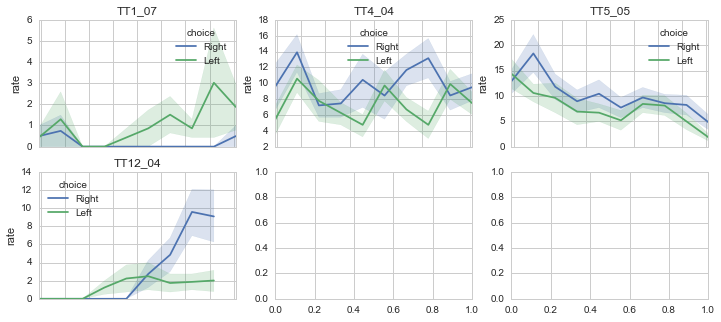

In [67]:
print len(decisionCells)
ArrPlotRows =1
if len(decisionCells) > 2:
    ArrPlotRows = int(np.ceil(len(decisionCells)/3.0))
f,ax = pl.subplots(ArrPlotRows,3,figsize= [12,len(decisionCells)*4/3])
for iii,cell in enumerate(decisionCells):
    row = iii/3
    col = np.mod(iii,3)
    sns.tsplot(cell,time='position',unit='lap',condition='choice',value='rate',ax=ax[row,col])
    ax[row,col].set_title(cell['cell_id'][0].any())
    ax[row,col].set_xticklabels('')
    ax[row,col].set_xlabel('')

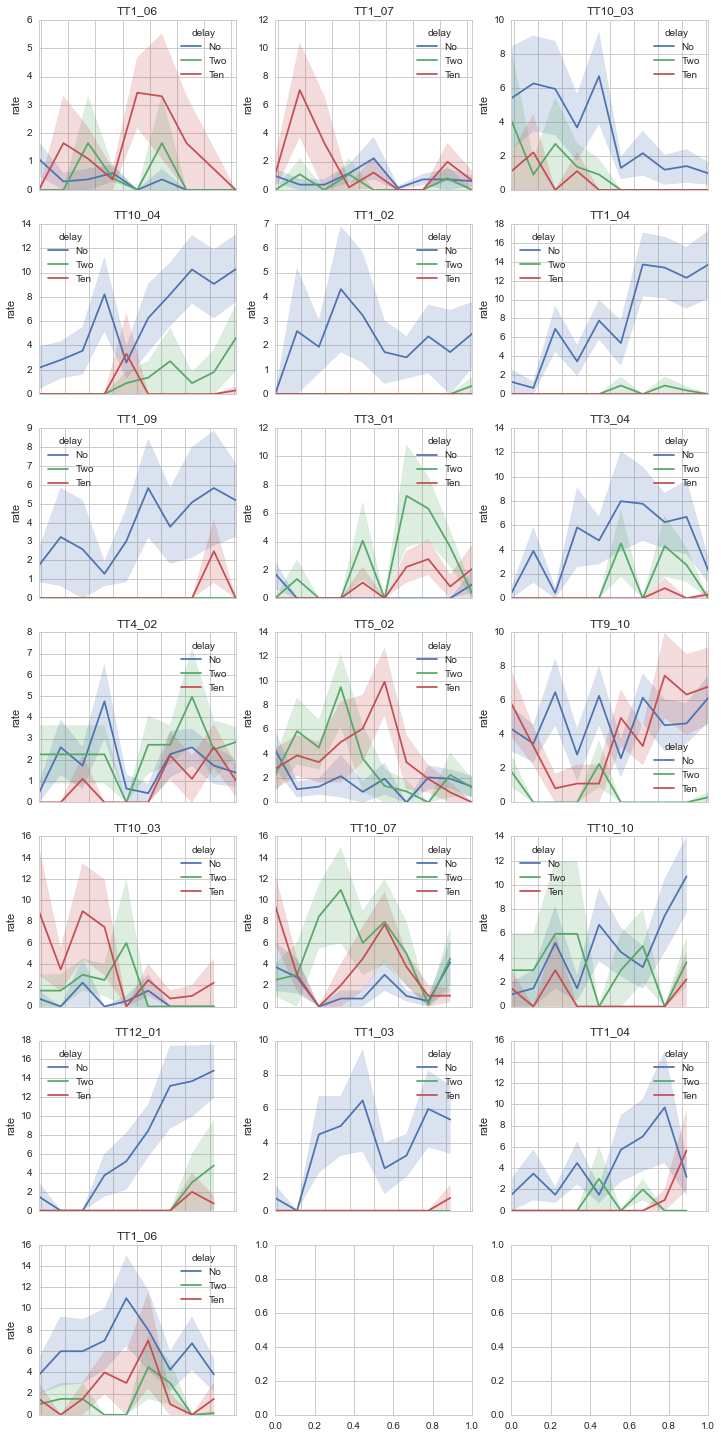

In [71]:
f,ax = pl.subplots(int(np.ceil(len(timeCells)/3.0)),3,figsize= [12,len(timeCells)*4/3])
for iii,cell in enumerate(timeCells):
    row = iii/3
    col = np.mod(iii,3)
    sns.tsplot(cell,time='position',unit='lap',condition='delay',value='rate',ax=ax[row,col])
    ax[row,col].set_title(cell['cell_id'][0].any())
    ax[row,col].set_xticklabels('')
    ax[row,col].set_xlabel('')

IndexError: index 2 is out of bounds for axis 0 with size 2

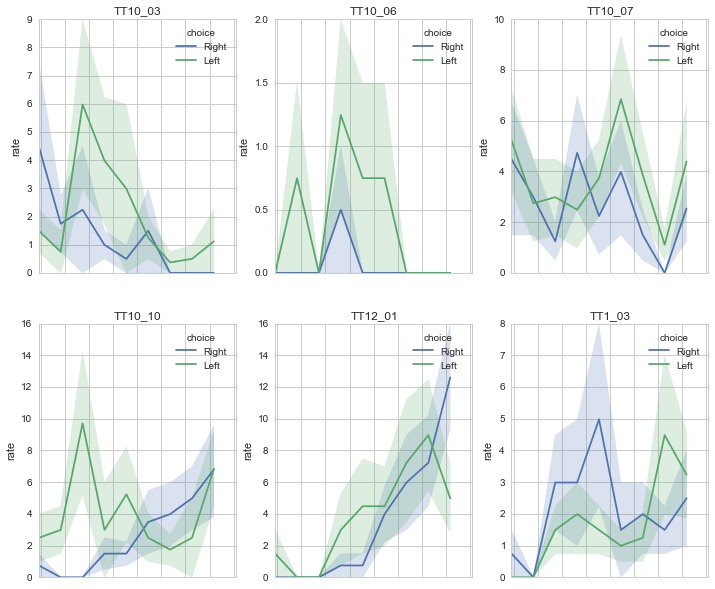

In [58]:
f,ax = pl.subplots(int(np.ceil(len(place_cell_ids)/3.0)),3,figsize= [12,len(time_cell_ids)*4/3])
for iii,id in enumerate(time_cell_ids):
    cell = cellDB[id]
    row = iii/3
    col = np.mod(iii,3)
    sns.tsplot(cell,time='position',unit='lap',condition='choice',value='rate',ax=ax[row,col])
    ax[row,col].set_title(cell['cell_id'][0].any())
    ax[row,col].set_xticklabels('')
    ax[row,col].set_xlabel('')

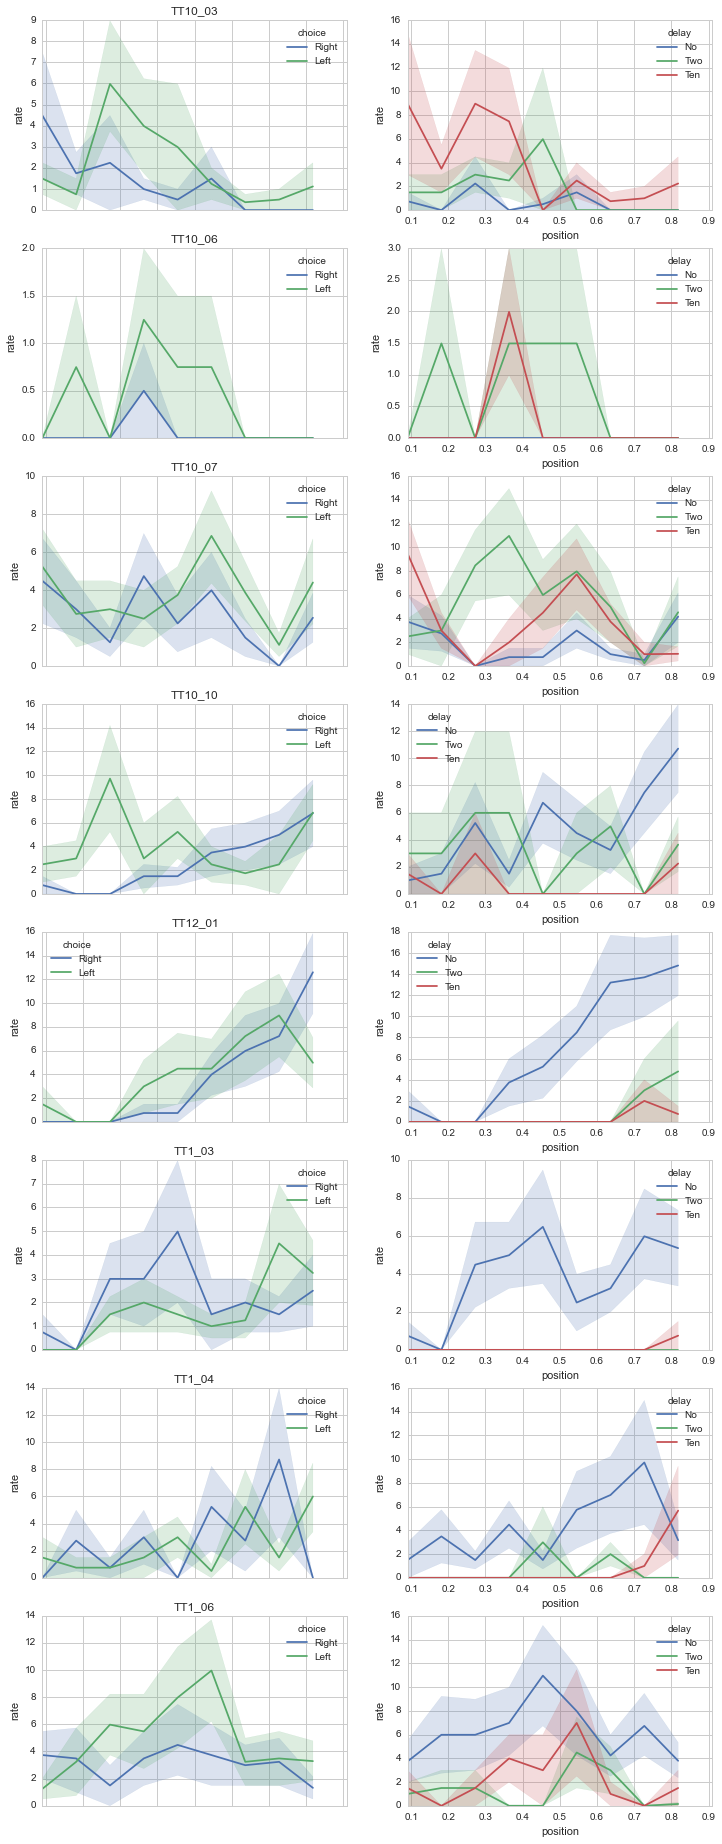

In [6]:
f,ax = pl.subplots(len(time_cell_ids),2,figsize= [12,len(time_cell_ids)*4])
for iii,id in enumerate(time_cell_ids):
    cell = cellDB[id]
    sns.tsplot(cell,time='position',unit='lap',condition='choice',value='rate',ax=ax[iii,0])
    sns.tsplot(cell,time='position',condition='delay',unit='lap',value='rate',ax=ax[iii,1])
    ax[iii,0].set_title(cell['cell_id'][0].any())
    ax[iii,0].set_xticklabels('')
    ax[iii,0].set_xlabel('')

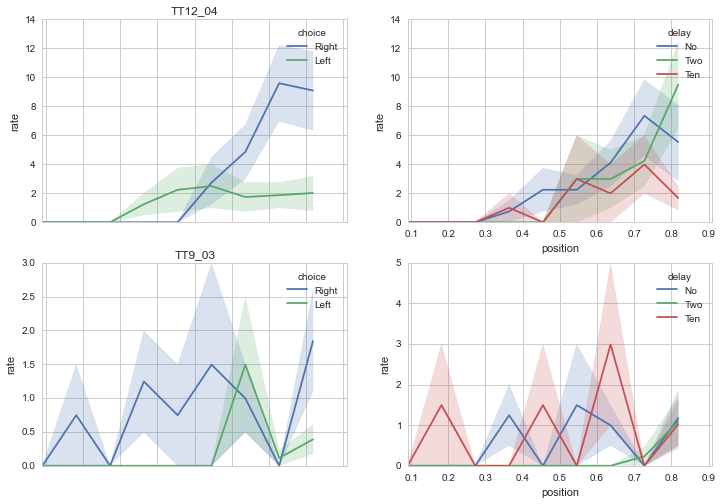

In [138]:
f,ax = pl.subplots(len(decision_cell_ids),2,figsize= [12,len(decision_cell_ids)*4])
for iii,id in enumerate(decision_cell_ids):
    cell = cellDB[id]
    sns.tsplot(cell,time='position',unit='lap',condition='choice',value='rate',ax=ax[iii,0])
    sns.tsplot(cell,time='position',condition='delay',unit='lap',value='rate',ax=ax[iii,1])
    ax[iii,0].set_title(cell['cell_id'][0].any())
    ax[iii,0].set_xticklabels('')
    ax[iii,0].set_xlabel('')

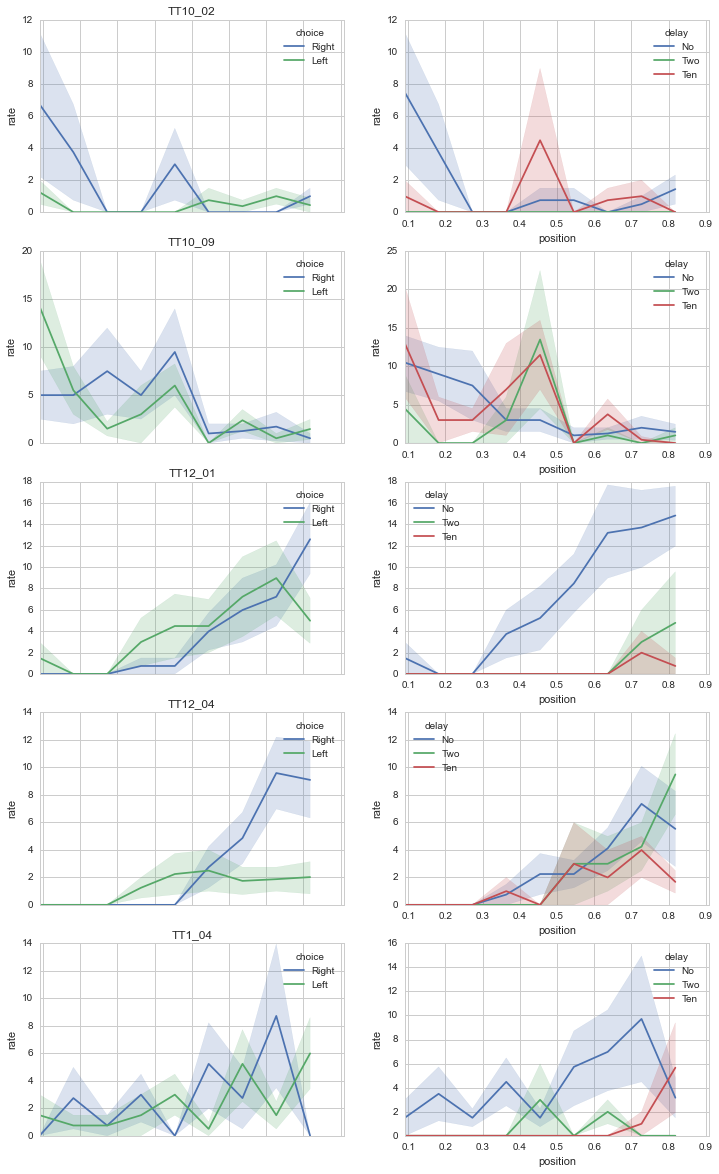

In [139]:
f,ax = pl.subplots(len(place_cell_ids),2,figsize= [12,len(place_cell_ids)*4])
for iii,id in enumerate(place_cell_ids):
    cell = cellDB[id]
    sns.tsplot(cell,time='position',unit='lap',condition='choice',value='rate',ax=ax[iii,0])
    sns.tsplot(cell,time='position',condition='delay',unit='lap',value='rate',ax=ax[iii,1])
    ax[iii,0].set_title(cell['cell_id'][0].any())
    ax[iii,0].set_xticklabels('')
    ax[iii,0].set_xlabel('')

In [117]:
ratio = []
for cell in decisionCells:
    ll = cell[cell['choice']== 'Left']
    rr = cell[cell['choice']== 'Right']
    for posBin in np.arange(0,0.9,0.1):
        selL = ll[ll['position']>posBin]
        selL = selL[selL['position']<posBin+0.1]
        selR = rr[rr['position']>posBin]
        selR= selR[selR['position']<posBin+0.1]
        ratio.append((selL.rate.mean()-selR.rate.mean())**2/
                    (selL.rate.mean()+selR.rate.mean()))
        #ratio.append(np.max([selL.rate.mean(),selR.rate.mean()])/
        #             np.min([selL.rate.mean(),selR.rate.mean()]))
    print '*******************'
ratio = np.array(ratio)

*******************
*******************
*******************
*******************


In [118]:
ratio = ratio[~np.isnan(ratio)]
ratio = ratio[~np.isinf(ratio)]

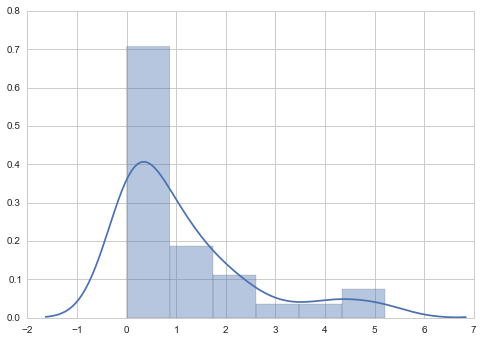

In [122]:
sns.distplot(ratio)#bins=np.arange(0,1.2,0.1));

In [124]:
ratio

array([  4.51804822e-03,   1.48533823e-01,   4.31724607e-01,
         8.63449215e-01,   1.51103613e+00,   8.63449215e-01,
         3.02207225e+00,   1.15768138e+00,   4.51445361e-01,
         2.18585873e-02,   1.02832042e-01,   2.12389469e+00,
         8.93479999e-02,   1.34847950e+00,   3.94798361e+00,
         1.13872100e-01,   7.67225559e-02,   2.09779204e+00,
         2.23245992e-01,   2.59858217e-01,   8.14696455e-01,
         4.91154594e-01,   8.81019402e-02,   1.32317928e-02,
         8.02785374e-01,   1.24548517e+00,   2.24187331e+00,
         1.18617636e-02,   1.46873252e+00,   5.20396197e+00,
         4.50176008e+00])

In [105]:
ratio100 = []
ratio20 = []
ratio210 = []
for cell in timeCells:
    nn = cell[cell['delay']== 'No']
    tt = cell[cell['delay']== 'Two']
    tn = cell[cell['delay']== 'Ten']
    for posBin in np.arange(0,0.9,0.1):
        sel0 = nn[nn['position']>posBin]
        sel0 = sel0[sel0['position']<posBin+0.1]
        sel2 = tt[tt['position']>posBin]
        sel2 = sel2[sel2['position']<posBin+0.1]
        sel10 = tn[tn['position']>posBin]
        sel10 = sel10[sel10['position']<posBin+0.1]
        ratio100.append(np.max([sel10.rate.mean(),sel0.rate.mean()])/
                     np.min([sel10.rate.mean(),sel0.rate.mean()]))
        ratio20.append(np.max([sel2.rate.mean(),sel0.rate.mean()])/
                     np.min([sel2.rate.mean(),sel0.rate.mean()]))
        ratio210.append(np.max([sel10.rate.mean(),sel2.rate.mean()])/
                     np.min([sel10.rate.mean(),sel2.rate.mean()]))
    print '*******************'
ratio100 = np.array(ratio100)
ratio210 = np.array(ratio210)
ratio20 = np.array(ratio20)

*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************
*******************


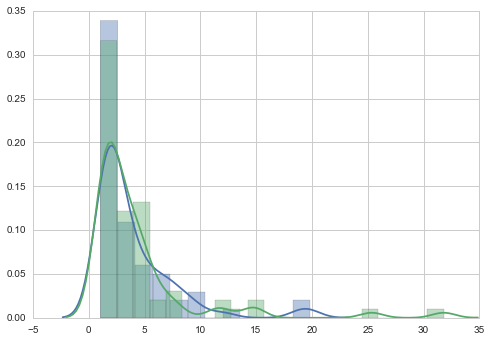

In [109]:
ratio100 = ratio100[~np.isnan(ratio100)]
ratio100 = ratio100[~np.isinf(ratio100)]
ratio210 = ratio210[~np.isnan(ratio210)]
ratio210 = ratio210[~np.isinf(ratio210)]
ratio20 = ratio20[~np.isnan(ratio20)]
ratio20 = ratio20[~np.isinf(ratio20)]
sns.distplot(ratio100);
#sns.distplot(ratio210)
sns.distplot(ratio20)

In [107]:
print stats.ks_2samp(ratio100,ratio210)
print stats.ks_2samp(ratio100,ratio20)
print stats.ks_2samp(ratio20,ratio210)

(0.13265931372549022, 0.66863256515801595)
(0.096781716417910446, 0.9045269575969469)
(0.12291483757682176, 0.7463459900497178)
